In [505]:
import pandas as pd     
import time 
from bs4 import BeautifulSoup
from selenium import webdriver 
from selenium.webdriver.chrome.service import Service 
from selenium.webdriver.common.by import By 
from selenium.webdriver.common.keys import Keys 
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import tqdm
import numpy as np
import pymorphy3
import re

In [532]:
wb = webdriver.Chrome(service=Service())

In [498]:
morph = pymorphy3.MorphAnalyzer()

In [302]:
list_of_links_to_pages = []
request = input()
request = request.split()
for i in range(15):
    request_fin = ''
    for j in request:
        request_fin += '+' + j
    link = f'https://hh.ru/search/vacancy?area=113&text={request_fin[1:]}&L_save_area=true&page={i}'
    list_of_links_to_pages.append(link)


data scientist


In [306]:
def getting_vacancies_links(list_of_links):
    clean_spisok = []
    spisok = []
    for k in tqdm.tqdm(list_of_links):
        wb.get(k)
        time.sleep(3)
        html = wb.page_source 
        soup = BeautifulSoup(html) 
        for i in soup.find_all('span', {'class' : 'serp-item__title-link-wrapper'}):
            for j in i.descendants:
                try:
                    spisok.append(j.get('href'))
                except:
                    pass
        for i in spisok:
            if i is not None:
                clean_spisok.append(i)
    return clean_spisok
    

In [307]:
vacancies_links = []
vacancies_links = getting_vacancies_links(list_of_links_to_pages)

100%|███████████████████████████████████████████| 15/15 [01:45<00:00,  7.06s/it]


In [309]:
mno = set(vacancies_links)
vacancies_links = list(mno)
len(vacancies_links)


474

In [561]:
russian_stopwords = pd.read_csv('https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt', header=None, names=['words'])
russian_stopwords = list(russian_stopwords['words'])
df = pd.DataFrame(columns=['Job title','Company','Company Rating','Salary','Experience','Work mode', 'Skills', 'Location', 'Link'])
c = 1
list_of_words = []
for i in tqdm.tqdm(vacancies_links):
    wb.get(i)
    time.sleep(0.5)
    html = wb.page_source 
    soup = BeautifulSoup(html)
    try:
        j = soup.find('div', {'class' : 'vacancy-branded-user-content', 'itemprop' : 'description'}).text
        j = j.lower() 
        j = re.findall('[а-яё]+', j)
        clean_words = [i for i in j if i not in russian_stopwords] 
        final_words = [morph.parse(i)[0].normal_form for i in clean_words]
        for o in final_words:
            list_of_words.append(o)
    except:
        try:
            j = soup.find('div', {'class' : 'vacancy-description'}).text.split()
            j = j.lower() 
            j = re.findall('[а-яё]+', j)
            clean_words = [i for i in j if i not in russian_stopwords] 
            final_words = [morph.parse(i)[0].normal_form for i in clean_words]
            for o in final_words:
                list_of_words.append(o)
        except:
            pass
    try:
        title = soup.find('h1', {'data-qa' : 'vacancy-title'}).text
    except:
        title = np.nan
    try:
        salary = soup.find('span', {'data-qa' : 'vacancy-salary-compensation-type-net'}).text.split()
        salary = ' '.join(salary)
    except:
        salary = np.nan
    try:
        ex = soup.find('span', {'data-qa' : 'vacancy-experience'}).text
        exp = ''
        for i in ex:
            if not i.isalpha():
                exp += i
    except:
        exp = np.nan
    try:
        location = soup.find('p', {'data-qa' : 'vacancy-view-location'}).text
    except:
        try:
            location = soup.find('span', {'data-qa' : 'vacancy-view-raw-address'}).text.split()[0][:-1]
        except:
            location = np.nan
    try:
        mode = soup.find('p', {'data-qa' : 'vacancy-view-employment-mode'}).text
    except:
        mode = np.nan
    try:
        company = soup.find('span', {'data-qa' : 'bloko-header-2'}).text.split()
        company = ' '.join(company)
    except:
        company = np.nan
    try:
        rating = soup.find('div', {'data-qa' : 'employer-review-small-widget-total-rating'}).text
    except:
        rating = np.nan
    try:
        skills = set()
        for i in soup.find('ul', {'class' : 'vacancy-skill-list--COfJZoDl6Y8AwbMFAh5Z'}).descendants:
            skills.add(i.text)
        skills = ', '.join(skills)
    except:
        skills = np.nan
    data = {'Job title' : title,'Company' : company,'Company Rating' : rating,'Salary' : salary,'Experience' : exp,'Work mode' : mode, 'Skills' : skills, 'Location' : location, 'Link' : wb.current_url}
    job_df = pd.DataFrame(data, index=[c])
    df = pd.concat([df, job_df])
    c += 1  

100%|█████████████████████████████████████████| 474/474 [15:43<00:00,  1.99s/it]


In [562]:
df

,Job title,Company,Company Rating,Salary,Experience,Work mode,Skills,Location,Link
1,Data/ML Engineer,Gravity Field,"4,4",NaN,3–6,"Полная занятость, полный день",NaN,Москва,https://hh.ru/vacancy/97622522?query=data+scie...
2,"Data Scientist, Маркетплейс, Контент и товары",Ozon Информационные технологии,"3,7",NaN,1–3,"Полная занятость, полный день","IT, ИТ, PyTorch, Python",Москва,https://hh.ru/vacancy/104725285?query=data+sci...
3,Data Scientist в центр AI маркетинга,Сбер для экспертов,"4,0",NaN,,"Полная занятость, полный день",NaN,Москва,https://hh.ru/vacancy/104702547?query=data+sci...
4,"Data Scientist/Analyst ""Платформа экспериментов""",Okko,"3,9",NaN,3–6,"Полная занятость, полный день","SQL, A/B тесты, Python",Москва,https://hh.ru/vacancy/104163209?query=data+sci...
5,Стажер Data Scientist в команду [Центр маркети...,"ПАО «МТС», Live","4,0",NaN,,"Полная занятость, полный день",NaN,Москва,https://hh.ru/vacancy/103649738?query=data+sci...
...,...,...,...,...,...,...,...,...,...
470,Менеджер по продажам курсов IT и интернет проф...,СИНЕРГИЯ,"4,2",от 100 000 до 130 000 ₽ на руки,,"Полная занятость, полный день","Телефонные переговоры, Консультирование клиент...",Москва,https://hh.ru/vacancy/104235641?query=data+sci...
471,Data Scientist / Дата Cайентист в online кинот...,ПАО «МТС» КИОН,"4,0",NaN,1–3,"Полная занятость, полный день","Apache Hive, Airflow, Hadoop, Python, Greenplu...",Москва,https://hh.ru/vacancy/104906369?query=data+sci...
472,Senior/Middle Data Scientist,ООО Страта Солюшенс,"4,2",NaN,3–6,"Полная занятость, полный день",NaN,Москва,https://hh.ru/vacancy/104428921?query=data+sci...
473,Middle data scientist,Альфа-Банк. Центральный офис,"4,3",NaN,1–3,"Полная занятость, полный день",NaN,Москва,https://hh.ru/vacancy/99117828?query=data+scie...


In [547]:
df['Location'].value_counts().head()

Location
Москва             355
Санкт-Петербург     37
Елабужски           12
Новосибирск          9
Самара               6
Name: count, dtype: int64

In [545]:
for i in df['Location'].value_counts().head():
    print(f'{round(round(i/df.shape[0], 2)*100)}%')

75%
8%
3%
2%
1%


In [548]:
df['Experience'].value_counts()

Experience
3–6     244
1–3     185
         22
 6       22
Name: count, dtype: int64

In [549]:
for i in df['Experience'].value_counts():
    print(f'{round(round(i/df.shape[0], 2)*100)}%')

51%
39%
5%
5%


In [560]:
df['Company'].value_counts().head(10)

Company
Сбер для экспертов    474
Name: count, dtype: int64

In [551]:
for i in df['Company'].value_counts():
    print(f'{round(round(i/df.shape[0], 2)*100)}%')

13%
4%
4%
3%
3%
2%
2%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%


In [639]:
df[df['Skills'].notna()].head(5)

,Job title,Company,Company Rating,Salary,Experience,Work mode,Skills,Location,Link
2,"Data Scientist, Маркетплейс, Контент и товары",Ozon Информационные технологии,"3,7",NaN,1–3,"Полная занятость, полный день","IT, ИТ, PyTorch, Python",Москва,https://hh.ru/vacancy/104725285?query=data+sci...
4,"Data Scientist/Analyst ""Платформа экспериментов""",Okko,"3,9",NaN,3–6,"Полная занятость, полный день","SQL, A/B тесты, Python",Москва,https://hh.ru/vacancy/104163209?query=data+sci...
6,Middle / Middle+ Data Scientist,X5 Digital,NaN,NaN,1–3,"Полная занятость, полный день","PyTorch, Deep Learning, Алгоритмы и структуры ...",Москва,https://hh.ru/vacancy/104831004?query=data+sci...
8,Data Scientist,ООО ГК Иннотех | Большие данные,"4,2",NaN,3–6,"Полная занятость, удаленная работа","Spark, Hadoop, ML, Python",Москва,https://hh.ru/vacancy/103973274?query=data+sci...
10,Data Scientist,boostra,"4,6",от 250 000 ₽ на руки,1–3,"Полная занятость, полный день","Классическое машинное обучение, Алгоритмы и ст...",Москва,https://hh.ru/vacancy/104921123?query=data+sci...


In [625]:
df_notnull = df[df['Skills'].notna()]
df_notnull.loc[df_notnull['Skills'].str.contains('ML') & ~df_notnull['Skills'].str.contains('Machine Learning')].count() / df_notnull.shape[0] * 100

Job title         16.600791
Company           16.600791
Company Rating    14.624506
Salary             0.790514
Experience        16.600791
Work mode         16.600791
Skills            16.600791
Location          16.600791
Link              16.600791
dtype: float64

In [636]:
df_notnull.loc[df_notnull['Skills'].str.contains('GPU')].count() / df_notnull.shape[0] * 100

Job title         0.395257
Company           0.395257
Company Rating    0.395257
Salary            0.000000
Experience        0.395257
Work mode         0.395257
Skills            0.395257
Location          0.395257
Link              0.395257
dtype: float64

In [644]:
df_notnull.shape[0]

253

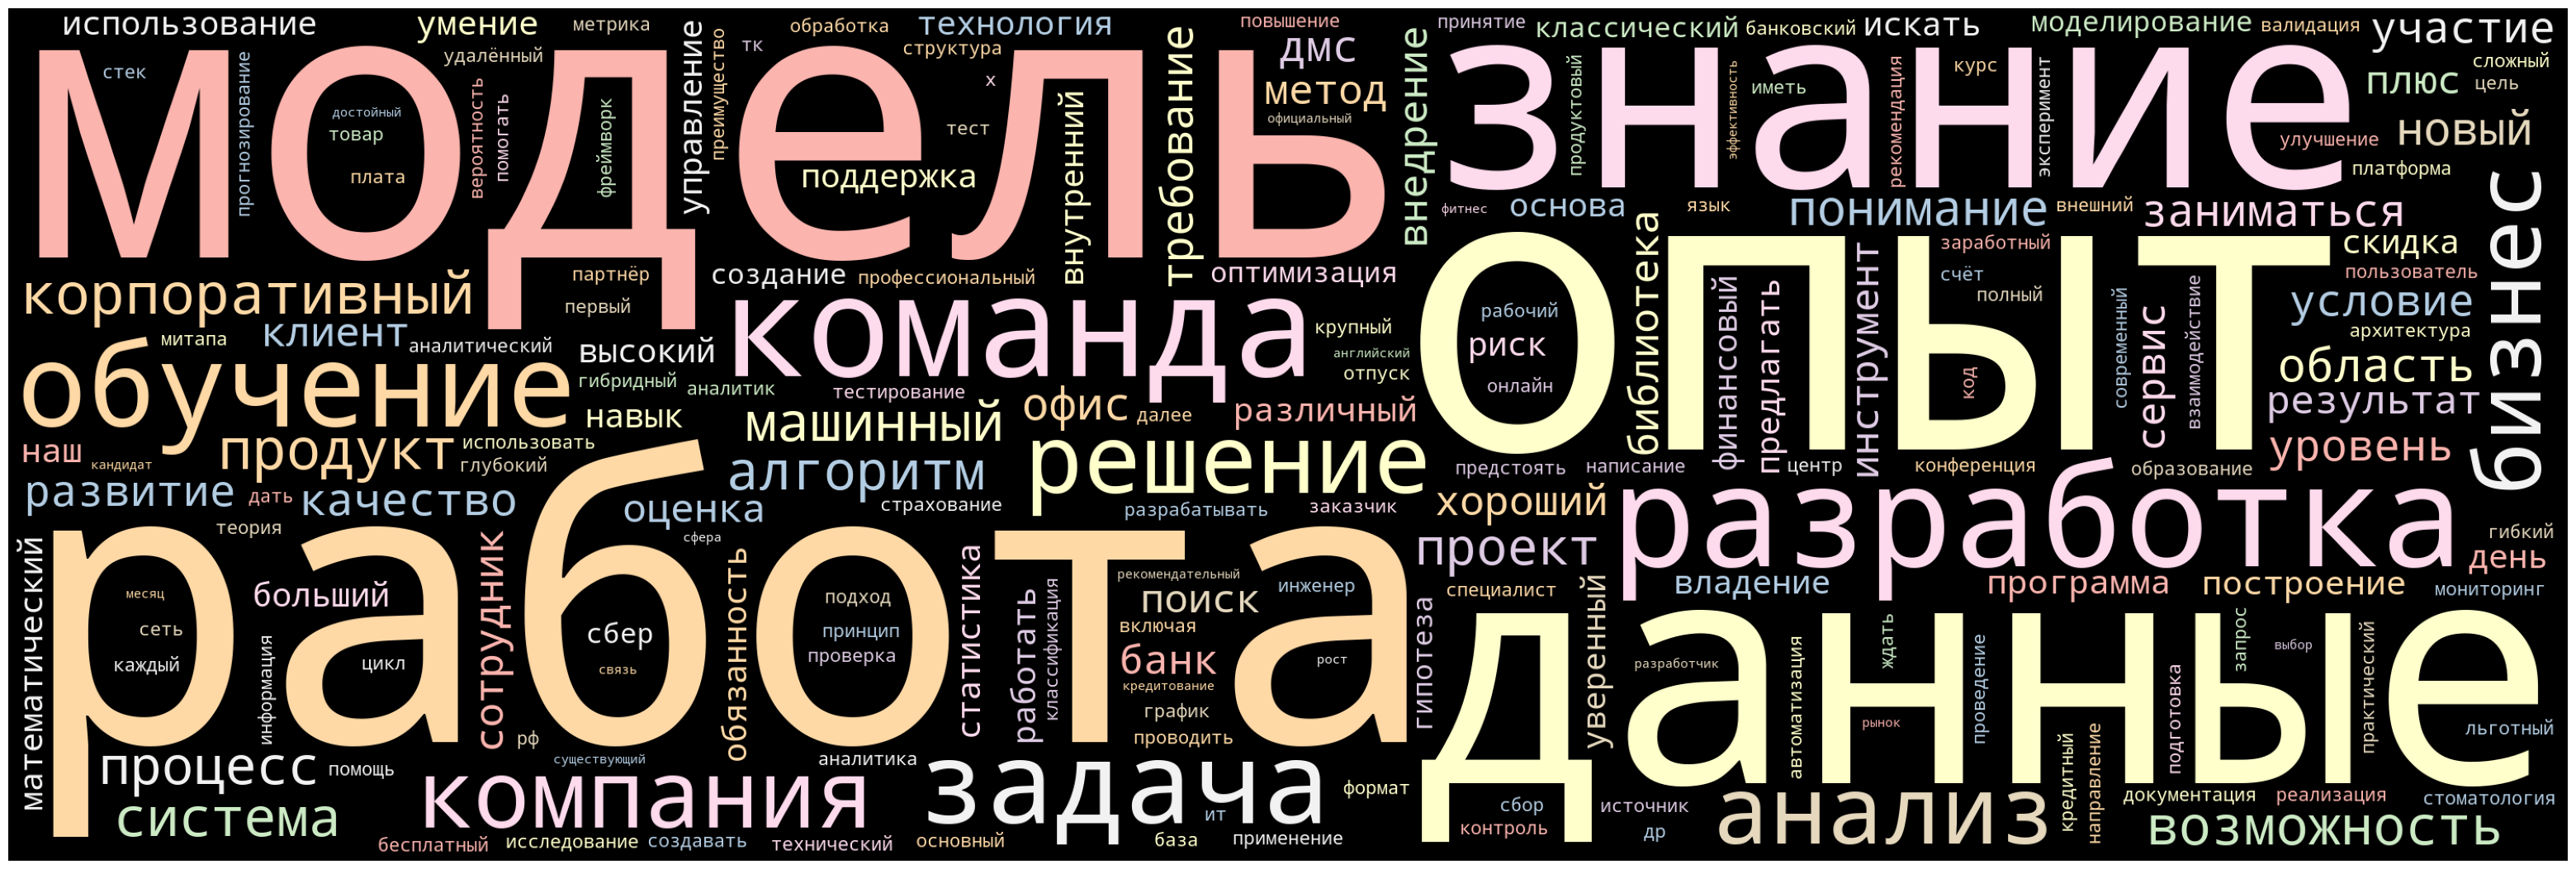

In [638]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


text = ' '.join(list_of_words)

wordcloud1 = WordCloud(width = 3000, height = 1000, random_state = 13, 
                       background_color = 'black', margin = 20, colormap = 'Pastel1',
                       collocations = False).generate(text)
def plot_cloud(wordcloud1):
    plt.figure(figsize = (40, 30))
    plt.axis('off')
    return plt.imshow(wordcloud1)

plot_cloud(wordcloud1)
